In [1]:
"""
This program generates graphs with regular cycles.
"""
import simpy
import matplotlib.pyplot as plt
import numpy as np
from random import randint
# import aux


In [2]:
import mercury as mr
app = mr.App(title="Cycles!", description="Slider demo", show_code=False)

mercury.App

In [3]:
time = mr.Slider(label="Time", value=576, min=0, max=10000)

mercury.Slider

In [4]:
"""
Plot graphs with more readable xlims and ylims.
Parameters:
    time_x(list(ints)): The x values for the graph.
    gaussian_y(list(floats)): The y values for the graph.
"""
def lim_plots(time_x, gaussian_y):
    fig, ax = plt.subplots(figsize=(12, 6))
    x = time_x
    y = gaussian_y
    ax.plot(y)
    #the x axis should show 0 through time
    plt.xlim([0, len(time_x)-1])
    #the y axis shows twice the highest y value
    plt.ylim([0, max(gaussian_y) * 2])
    plt.xlabel("Time")
    plt.ylabel("Requests")
    plt.show()

In [5]:
"""
Parameters:
    mean(int): The mean of the distribution.
    sd(int): The standard deviation of the distribution.
    time(int): The number of points to generate.
    new_dist(list(lists)): The new distribution to follow. Should be in this form.
    [[end1,freq1], [end2,freq2]...] The first entry in the list should be the percentage of the graph this section of the distribution will go up to, and the second should be the probability that any random point generated with this distribution falls within that sections of the graph. For example, a distribution of [[0.5, 0.9], [1, 0.1]] will have 90% of points fall within the first half of the graph and 10% of points fall within the second half.  
Returns: 
    requests_y(list(floats)): a series of randomly generated numbers along said distribution.
"""
def unique_norm(middle, sd, time, custom_dist):
    #based off of the usual range of standard deviations: approximate, however.
    start = middle - sd * 4
    end = middle + sd * 4
    requests_y = []
    #for each point
    for i in range(time):
        rand_num = np.random.random()
        #the total number that rand_num must be below in order to fall into a certain probability block
        freq_sum = 0
        #for each of the distribution's blocks of probability
        for freq in range(len(custom_dist)):
            #ensures upper bound of probability is always increased
            #that way all points will eventually be added (because sum of all 
            freq_sum += custom_dist[freq][1]
            #if the random number is less than that sum
            if rand_num < freq_sum:
                #determine the range of the point's actual value
                upper_bound = start + ((abs(end)-start)*custom_dist[freq][0])
                #if this is the first probability block
                if freq == 0:
                    #then the range will be from 0 to the upper_bound
                    requests_y.append(np.random.uniform(start, upper_bound))
                    #exit this loop so it is not added again
                    break
                else:
                    requests_y.append(np.random.uniform(custom_dist[freq-1][0], upper_bound))
                    break
        #if we've reached the number of points requested
        if len(requests_y) == time:
            #leave loop
            break
    return requests_y

In [6]:
"""
Generates a graph with cyclical patterns, i.e. with consistent periods of rising and falling. 
Parameters:
    low_mean(int): The mean of a gaussian distribution to be used in the low part of cycle
    low_sd(int): The standard deviation of a gaussian distribution to be used in the low part of cycle
    high_mean(int): The mean of a gaussian distribution to be used in the high part of cycle
    high_sd(int): The standard deviation of a gaussian distribution to be used in the high part of cycle
    time(int): The number of points to be generated.
    set_cycles(list(lists)): Set to None by default, under which it will create one random cycle.
        To create other kind of cycles, set_cycles should be a list of 3-item lists with the cycle's start, high, and end points.
        First entry in list is start of cycle, second is the high point of the cycle, third and final is last point of the cycle. 
    graph(bool): Whether to show a graph of time vs. generated distribution, default True
    custom_dist(list(lists): A list of two-entry lists that describe a custom distribution. For further details, see the
    readme, or the unique_norm function in aux.py. Defaults to None, or a normal distribution.
Returns:
    gaussian_y(list(floats)): The generated distribution.
"""
def cycles_gen(low_mean, low_sd, time, high_mean, high_sd, set_cycles = None, custom_dist = None, graph = True):
    #Note: when 'cycle descriptor' is mentioned in this function, it refers to the three-entry list from
    #which cycles are generated (see set_cycles description above)
    time_x = [i for i in range(time)]
    
    #if there is not any set cycles, generate one random one.
    if set_cycles == None:
        rand_start = randint(0, time-1)
        rand_end = randint(0, time-1)
        #generate a high point between start and end, wrapping around if necessary
        if rand_end > rand_start: rand_high = randint(rand_start, rand_end)
        else: rand_high = randint(rand_start, rand_start + (rand_end % time))
        #wrapping around
        if rand_high > time:
            rand_high = rand_high - time
        #create the single cycle
        set_cycles = [[rand_start, rand_high, rand_end]]
    #create a dictionary of range of points to descriptor of cycle
    print(set_cycles)
    #create a dictionary for keeping track of the cycles. This dictionary will map all the points in a cycle
    #to the descriptor that create them
    highs = dict()
    
    #determine cycle high points
    for cycle in set_cycles:
        cycle_points = []
        #if the start is less than the end, then add every point between them to the list of points
        if cycle[0] <= cycle[2]:
            for i in range(cycle[0], cycle[2]+1): cycle_points.append(i)
        else: #this means it loops around to the beginning of the graph
            #first add everything from start of cycle to end of time
            for i in range(cycle[0], time): cycle_points.append(i)
            #then, add everything from beginning of time to end to the highs
            for i in range(cycle[2]+1): cycle_points.append(i)
        #set as tuple so it can be a key    
        cycle_points = tuple(cycle_points)
        highs[cycle_points] = cycle
                
    #now to create distribution
    gaussian_y = []
    if not custom_dist:
        for i in range(time):
            
            #points on the graph are influenced by the preceeding point (0.5 is arbitrary)
            if i != 0: influence = gaussian_y[i-1] * 0.1
            else: influence = 0
                
            #if the current point is in any of the values of highs, aka is in any of the cycles
            if any(i in cycle_points for cycle_points in highs.keys()):
                #for each of the lists of points in highs.keys()
                for cycle_points in highs.keys():
                    #if this is the cycle that i is present in
                    if i in cycle_points:
                        #retrieve the appropriate cycle descriptor
                        cycle = highs[cycle_points]
                        mean_dif = high_mean - low_mean
                        #determine how far apart the cycles high point is from the start, and from the end
                        #index used to account for wrapping around
                        to_top = cycle_points.index(cycle[1]) - cycle_points.index(cycle[0])
                        to_low = cycle_points.index(cycle[2]) - cycle_points.index(cycle[1])
                        #if we at an earlier point than the top
                        if cycle_points.index(i) < cycle_points.index(cycle[1]):
                            position = cycle_points.index(i) - cycle_points.index(cycle[0])
                            #set the mean to be the starting mean + the difference between the high and low mean,
                            #divided by the distance between the highest point and the start of the cycle (i.e,
                            #how far each 'step' should take you)
                            #multiplied by how far you are into the cycle (i.e, how many steps you've taken)
                            mean = low_mean + ((mean_dif / to_top) * position)
                        else:
                            #start position a 0 and increase and it gets closer to end point
                            position = cycle_points.index(i) - cycle_points.index(cycle[1])
                            mean = high_mean - ((mean_dif / to_low) * position)
                        #next point is based off the mean created above
                        next = np.random.normal(mean, high_sd) + influence
            #if not in a cycle, simply use low_mean
            else: next = np.random.normal(low_mean, low_sd) + influence
            gaussian_y.append(next)
                
    else:
        for i in range(time):
            if i != 0: influence = gaussian_y[i-1] * 0.5
            else: influence = 0
            if i in highs: 
                next = unique_norm(high_mean, high_sd, 1, custom_dist)[0] + influence
            else: next = unique_norm(low_mean, low_sd, 1, custom_dist)[0] + influence
            gaussian_y.append(next)
    
    #add influence to first point now that final point is generated:
    influence = gaussian_y[len(gaussian_y)-1] * 0.5
    gaussian_y[0] = gaussian_y[0] + influence
    
    if graph: lim_plots(time_x, gaussian_y)

[[126, 203, 120]]


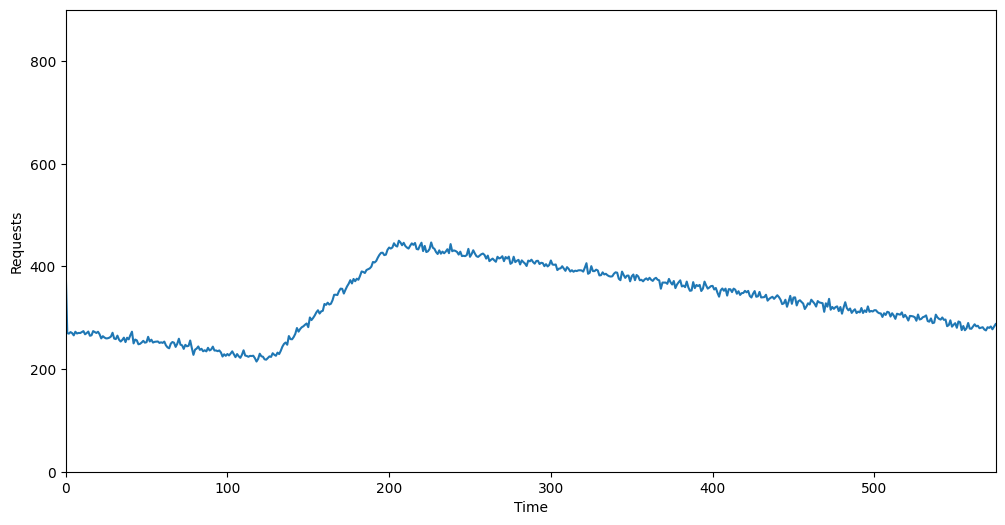

In [7]:
# cycles_gen(200,5,time.value,400,5,[[120,150,192],[528,0,72]])
# cycles_gen(200,5,time.value,400,5,[[12,14,18],[22,0,3]])
# cycles_gen(2000,5,time.value,400,31,[[5,6,7],[12,13,14]],[19,20,21],[26,27,28])
# cycles_gen(200,5,time.value,400,5)
cycles_gen(200,5,time.value,400,5)

#cycles_gen(200,5,576,400,5,[[120,150,192],[528,0,72]])
#cycles_gen(200,5,24,400,5,[[12,14,18],[22,0,3]])
#cycles_gen(2000,5,10000,400,31,[[5,6,7],[12,13,14]],[19,20,21],[26,27,28])
#cycles_gen(200,5,576,400,5)
#cycles_gen(200,5,24,400,5)